<a href="http://landlab.github.io"><img style="float: left" src="https://raw.githubusercontent.com/landlab/tutorials/master/landlab_header.png"></a>

# The deAlmeida Overland Flow Component 

<hr>
<small> For instructions on how to run an interactive iPython notebook, click here: <a href="https://github.com/landlab/tutorials/blob/master/README.md">https://github.com/landlab/tutorials/blob/master/README.md</a></small><br>
<small>For the unexpanded version to download and run, click here: <a href="https://nbviewer.jupyter.org/github/landlab/tutorials/blob/master/overland_flow/overland_flow_driver_unexpanded.ipynb">https://nbviewer.jupyter.org/github/landlab/tutorials/blob/master/overland_flow/overland_flow_driver_unexpanded.ipynb</a></small><br>
<small>For more Landlab tutorials, click here: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a></small>
<hr>

This notebook illustrates running the deAlmeida overland flow component in an extremely simple-minded way on a real topography, then shows it creating a flood sequence along an inclined surface with an oscillating water surface at one end.

First, import what we'll need:

In [1]:
from __future__ import print_function

from landlab.components.overland_flow import OverlandFlow
from landlab.plot.imshow import imshow_grid
from landlab.plot.colors import water_colormap
from landlab import RasterModelGrid
from landlab.io.esri_ascii import read_esri_ascii
from matplotlib.pyplot import figure
import numpy as np
from time import time
%matplotlib inline

Pick the initial and run conditions

In [2]:
run_time = 100           # duration of run, (s)
h_init = 0.1            # initial thin layer of water (m)
n = 0.01                  # roughness coefficient, (s/m^(1/3))
g = 9.8                   # gravity (m/s^2)
alpha = 0.7               # time-step factor (nondimensional; from Bates et al., 2010)
u = 0.4                   # constant velocity (m/s, de Almeida et al., 2012)
run_time_slices = (10,50,100)

Elapsed time starts at 1 second. This prevents errors when setting our boundary conditions.

In [3]:
elapsed_time = 1.0

Use Landlab methods to import an ARC ascii grid, and load the data into the field that the component needs to look at to get the data. This loads the elevation data, z, into a "field" in the grid itself, defined on the nodes.

In [4]:
rmg, z = read_esri_ascii('Square_TestBasin.asc')
rmg.add_field('node', 'topographic__elevation', z)
rmg.set_closed_boundaries_at_grid_edges(True, True, True, True)

We can get at this data with this syntax:

In [5]:
np.all(rmg.at_node['topographic__elevation'] == z)

True

Note that the boundary conditions for this grid mainly got handled with the final line of those three, but for the sake of completeness, we should probably manually "open" the outlet. We can find and set the outlet like this:

In [6]:
my_outlet_node = 100 # This DEM was generated using Landlab and the outlet node ID was known
rmg.status_at_node[my_outlet_node] = 1  # 1 is the code for fixed value

Now initialize a couple more grid fields that the component is going to need:

In [7]:
rmg.add_zeros('node', 'water__depth')                   # water depth (m)

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [8]:
rmg.at_node['water__depth'] += h_init

Let's look at our watershed topography

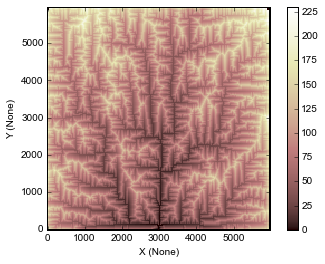

In [9]:
imshow_grid(rmg, 'topographic__elevation')

Now instantiate the component itself

In [10]:
of = OverlandFlow(rmg, steep_slopes = True) #for stability in steeper environments, we set the steep_slopes flag to True

Now we're going to run the loop that drives the component:

In [11]:
while elapsed_time < run_time:
    # First, we calculate our time step.
    dt = of.calc_time_step()
    # Now, we can generate overland flow.
    of.overland_flow()
    # Increased elapsed time
    print('Elapsed time: ', elapsed_time)
    elapsed_time += dt

Elapsed time:  1.0
Elapsed time:  22.2013286086
Elapsed time:  39.94939454
Elapsed time:  55.0723820405
Elapsed time:  68.1011721277
Elapsed time:  79.6427396372
Elapsed time:  90.0483576541
Elapsed time:  99.5944198234


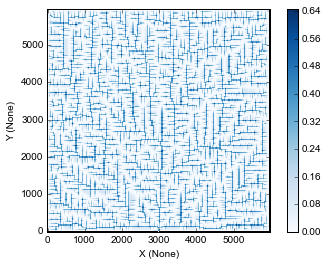

In [12]:
imshow_grid(rmg, 'water__depth', cmap='Blues')

Now let's get clever, and run a set of time slices:

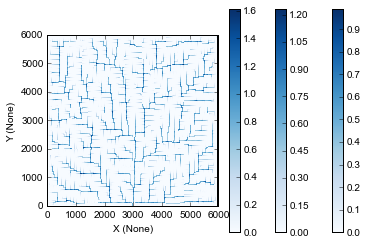

In [15]:
elapsed_time = 1.
for t in run_time_slices:
    while elapsed_time < t:
        # First, we calculate our time step.
        dt = of.calc_time_step()
        # Now, we can generate overland flow.
        of.overland_flow()
        # Increased elapsed time
        elapsed_time += dt
    figure(t)
    imshow_grid(rmg, 'water__depth', cmap='Blues')

### Click here for more <a href="https://github.com/landlab/landlab/wiki/Tutorials">Landlab tutorials</a>